In [1]:
import matplotlib.pyplot as plt

import numpy as np
from plotoptix import NpOptiX

In [2]:
width = 400
height = 300

def update_image(rt: NpOptiX) -> None:
    points_id = rt.geometry_data["points"]._handle
    f = rt._geo_id[:,:,0].reshape(rt._height, rt._width)
    f &= 0x3FFFFFFF # remove the vertex id info (bits 30 and 31)
    visible = f == points_id
    invisible = (f != points_id) * (f < 0x3FFFFFFF)
    empty = f == 0x3FFFFFFF
    f[visible] = 2
    f[invisible] = 1
    f[empty] = 0
    img.set_data(f)
    img.set_clim(vmin=0, vmax=2)
    plt.draw()

In [3]:


rt = NpOptiX(on_launch_finished=update_image, width=width, height=height, start_now=False, devices=[0])

# NOTE: no need for multiple passes, set up just 1 pass:
rt.set_param(min_accumulation_step=1, max_accumulation_frames=1)

from plotoptix.materials import m_flat

rt.setup_material("flat", m_flat)

rt.load_mesh_obj("../models/utah-teapot-1.obj", mat="flat")

In [4]:
u = np.linspace(-50, 50, width)
v = np.linspace(50, -50, height)
V, U = np.meshgrid(v, u)

xyz = np.stack((U, V, np.full((width, height), -15))).T

# optionally randomize positions - to see that rays really can follow set of irregular directions
xyz += 0.2 * np.random.rand(height, width, 3)

rt.set_data("points", xyz, r=0.1, mat="flat")

fov = 45 # field of view (vertical), in degrees

# equirectangular projection
a_ratio = width / height
u = np.linspace(-0.5 * a_ratio * fov / 180, 0.5 * a_ratio * fov / 180, width)
v = np.linspace(0.5 * fov / 180, -0.5 * fov / 180, height)

V, U = np.meshgrid(v, u)

fi_tex = np.stack((U, V)).T

rt.set_texture_2d("fi_tex", fi_tex)

eye = np.array([20.0, 50.0, 100.0])
target = np.array([0.0, 0.0, 0.0])
up = np.array([0.0, 1.0, 0.0])
rt.setup_camera("cam1", cam_type="CustomProj",
                eye=eye, target=target, up=up,
                textures=["fi_tex"])



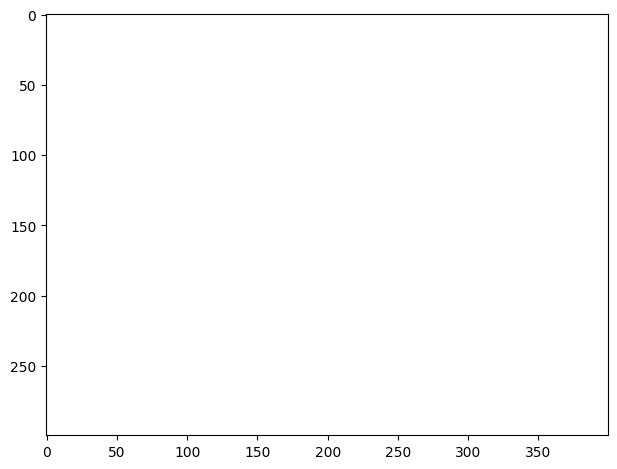

In [9]:
plt.figure(1)
img = plt.imshow(np.zeros((height,width,4)), cmap=plt.get_cmap("gnuplot"))
plt.tight_layout()
plt.show()

In [6]:
rt.start()

In [7]:
forward = target - eye
forward /= np.linalg.norm(forward)

up -= np.dot(forward, up) * forward
up /= np.linalg.norm(up)

right = np.cross(forward, up)

# not so pythonic, but instead very explicit math:
fi_tex2 = np.zeros((height, width, 2))
for iv in range(height):
    for iu in range(width):
        p = xyz[iv,iu] - eye
        
        pn = np.dot(p, right) * right
        pv = p - pn                         # eye->point vector projected on the camera "vertical" plane
        cv = np.dot(forward, pv/np.linalg.norm(pv))
        v = np.arccos(cv) * np.sign(np.dot(pv, up))
        
        pn = np.dot(p, up) * up
        pu = p - pn                         # eye->point vector projected on the camera "horizontal" plane
        cu = np.dot(forward, pu/np.linalg.norm(pu))
        u = np.arccos(cu) * np.sign(np.dot(pu, right))
        
        fi_tex2[iv,iu,0] = u
        fi_tex2[iv,iu,1] = v

fi_tex2 *= 1.0/np.pi

<Figure size 640x480 with 0 Axes>

In [8]:
rt.set_texture_2d("fi_tex", fi_tex2, refresh=True)

In [14]:
rt.close()